In [2]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
import imageio

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

In [3]:
# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        img_3d = imageio.imread(filename, pilmode = 'RGB')
    elif mode == 'L':
        img_3d = imageio.imread(filename, pilmode = 'L')
    # Downsample the image
    small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    blur = cv2.blur(small, (4, 4))
    return blur


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    elif mode == 'L':
        x, y = img_3d.shape
        img_2d = img_3d.reshape(x*y, 1)
        img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k, minit='points')
    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        cov = randint(low = 0, high = 500, size = (k, z, z))
        pis = random(size = k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, allow_singular=True, mean=means[j], cov=cov[j]) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, allow_singular=True,  mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 200):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)
    else:
        means, cov, pis = random_init(img, k)
    #print(means, cov, pis)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [4]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j]) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdf

In [5]:
FILENAME_LIST = ['/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia2.png',
 '/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia6.png',
 '/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia7.png']

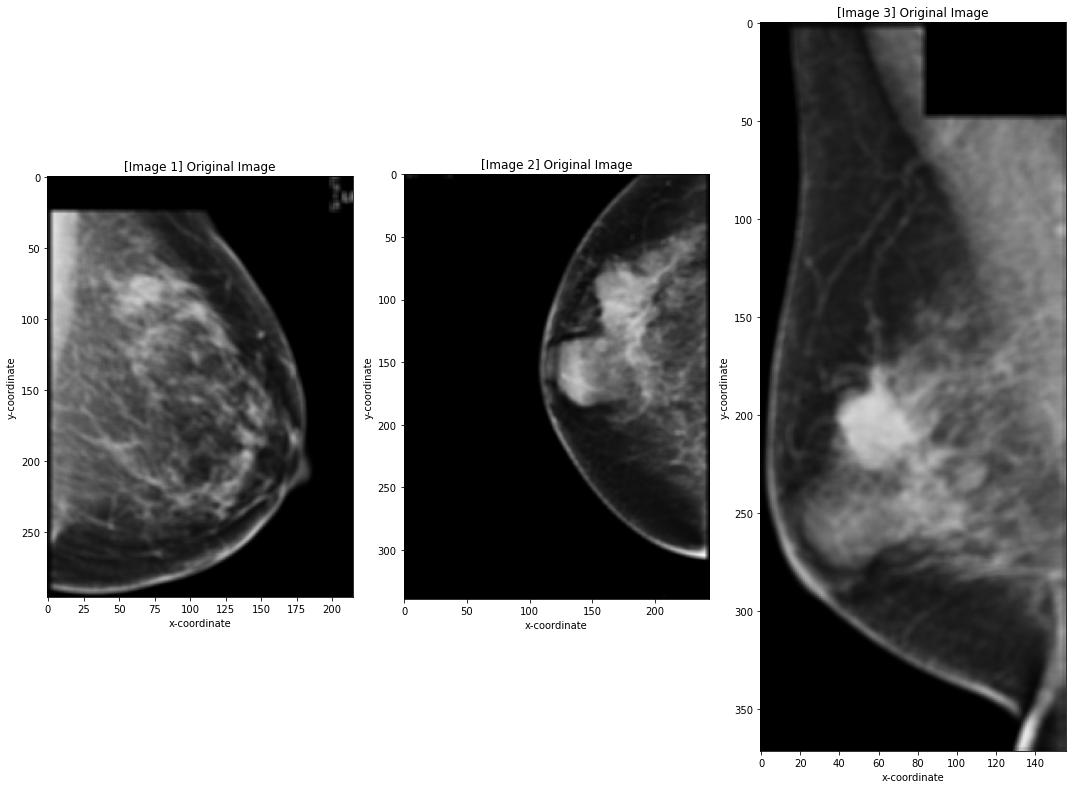

In [6]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
rgb_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    rgb_img = read_img(filename = filename, mode = 'RGB', size = (0.5, 0.5))
    x, y, z = rgb_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y,z))
    # Store img 
    rgb_img_list.append(rgb_img)
    ax.imshow(rgb_img)
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images_color.pdf')

In [7]:
img_list = [flatten_img(image, mode = 'RGB') for image in rgb_img_list]

In [8]:
# Run and Store KMeans image
from sklearn import cluster
from scipy.cluster.vq import kmeans2
kmeans_img_list = []

for img, dim in zip(img_list, dim_img_list):
    k_means, k_labels = kmeans2(img, 2, minit='points')
    k_means, k_labels
    kmeans_img = np.array([i[0] for i in k_means[k_labels]])
    kmeans_img = kmeans_img.reshape(dim[0], dim[1])
    kmeans_img_list.append(kmeans_img)

C:\Users\MayraBerrones\anaconda3\envs\vs1\lib\site-packages\scipy\cluster\vq.py:574: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


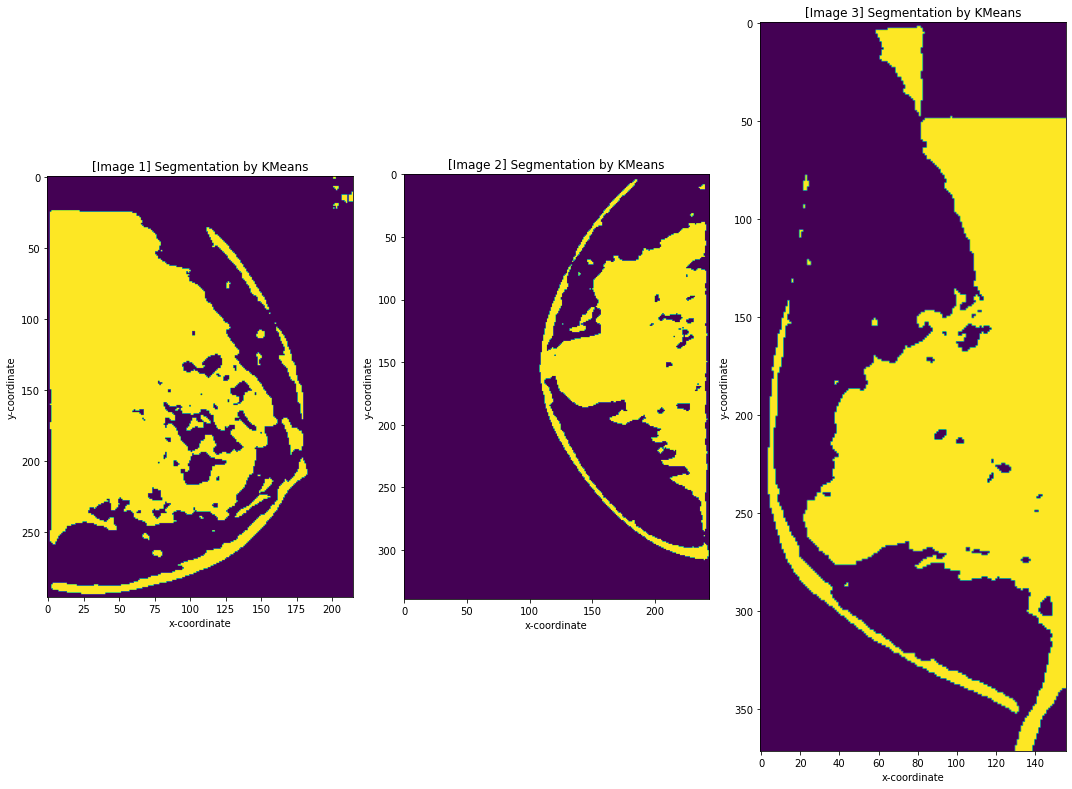

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for kmeans_img, ax, dim in zip(kmeans_img_list, ax_list, dim_img_list):
    ax.imshow(kmeans_img)
    ax.set_title('[Image {}] Segmentation first by k-means'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('kmeans_images.pdf')

In [10]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 2, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

iter: 1, time interval: 0:0:1:867420
log-likelihood = -366458.5803958208
iter: 2, time interval: 0:0:1:785403
log-likelihood = -365614.724501983
iter: 3, time interval: 0:0:1:861420
log-likelihood = -364815.01763608196
iter: 4, time interval: 0:0:1:821410
log-likelihood = -364034.05739414314
iter: 5, time interval: 0:0:1:893426
log-likelihood = -363242.8723883344
iter: 6, time interval: 0:0:1:874802
log-likelihood = -362386.0433903375
iter: 7, time interval: 0:0:1:919432
log-likelihood = -361350.3820963947
iter: 8, time interval: 0:0:1:768399
log-likelihood = -359851.207415668
iter: 9, time interval: 0:0:1:905429
log-likelihood = -356954.11955599947
iter: 10, time interval: 0:0:1:889425
log-likelihood = -349121.2934904232
iter: 11, time interval: 0:0:1:757396
log-likelihood = -327084.52852731966
iter: 12, time interval: 0:0:1:886425
log-likelihood = -297310.5250986195
iter: 13, time interval: 0:0:1:849464
log-likelihood = -274781.70749811654
iter: 14, time interval: 0:0:1:744393
log-li

C:\Users\MayraBerrones\anaconda3\envs\vs1\lib\site-packages\scipy\cluster\vq.py:574: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


iter: 1, time interval: 0:0:1:724542
log-likelihood = -333684.2511706417
iter: 2, time interval: 0:0:1:785908
log-likelihood = -333568.23172581656
iter: 3, time interval: 0:0:1:752394
log-likelihood = -333494.8461168859
iter: 4, time interval: 0:0:1:675377
log-likelihood = -333443.98318136437
iter: 5, time interval: 0:0:1:676378
log-likelihood = -333408.05446444376
iter: 6, time interval: 0:0:1:744392
log-likelihood = -333382.38054038706
iter: 7, time interval: 0:0:1:661374
log-likelihood = -333363.8246271069
iter: 8, time interval: 0:0:1:727390
log-likelihood = -333350.2654995096
iter: 9, time interval: 0:0:1:615372
log-likelihood = -333340.2583929219
iter: 10, time interval: 0:0:1:747385
log-likelihood = -333332.80780976714
iter: 11, time interval: 0:0:1:781402
log-likelihood = -333327.2184186476
iter: 12, time interval: 0:0:1:719386
log-likelihood = -333322.99787029333
iter: 13, time interval: 0:0:1:627911
log-likelihood = -333319.79306813783
iter: 14, time interval: 0:0:1:682924
lo

In [11]:
# Store density estimate (i.e pdf)
pdf_arr_list = []
for em_img, means, cov, pis in zip(em_img_list, means_list, cov_arr_list, pis_arr_list):
    pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    pdf_arr_list.append(pdf_arr)

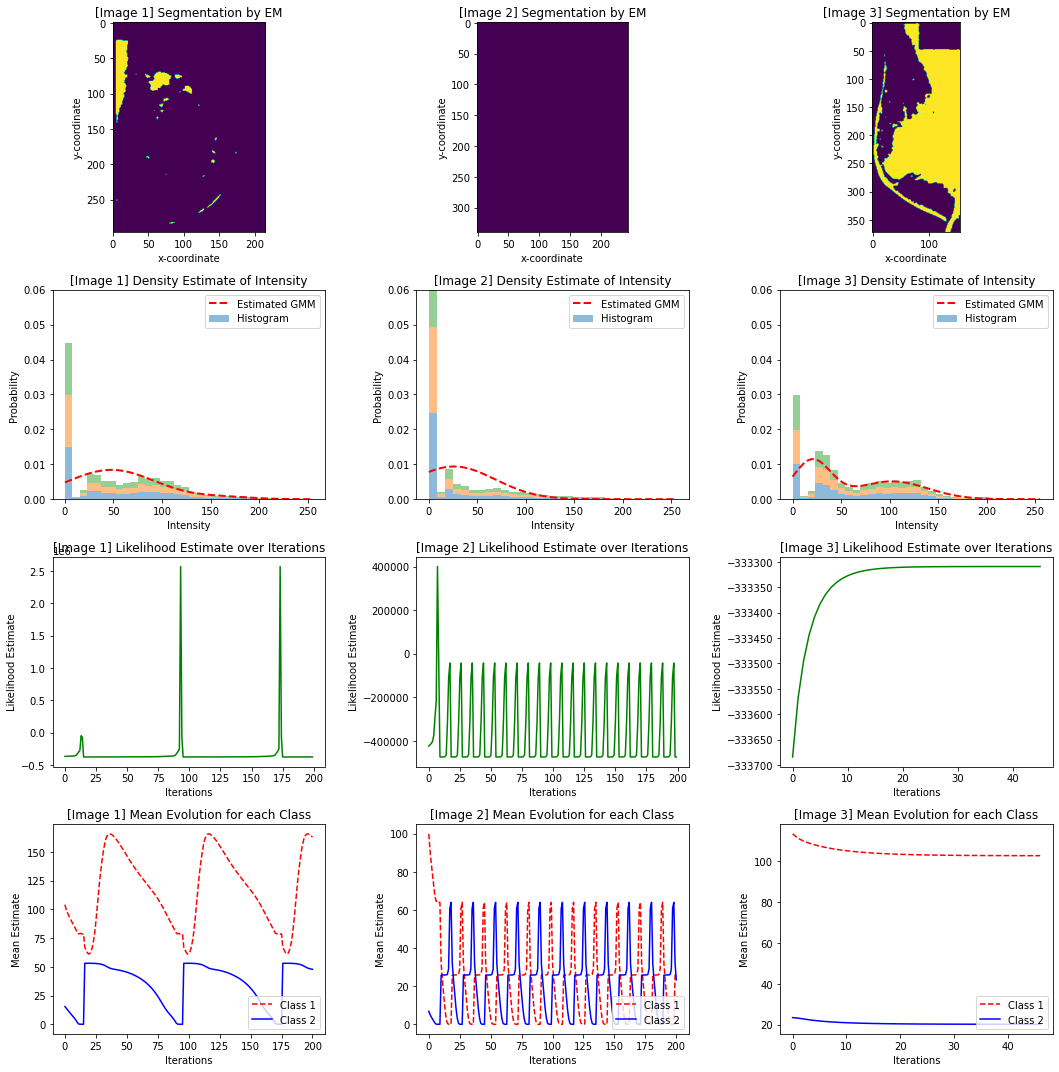

In [22]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for em_img, ax in zip(em_img_list, ax_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, density=True, stacked=True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1;
    
# THIRD ROW: density estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Likelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(means_arr_list, ax_list):
    # The 2nd image has class label inversed
    if i == 2:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout();
plt.savefig("em_kmeans_init.pdf")
plt.savefig("em_kmeans_init.png")

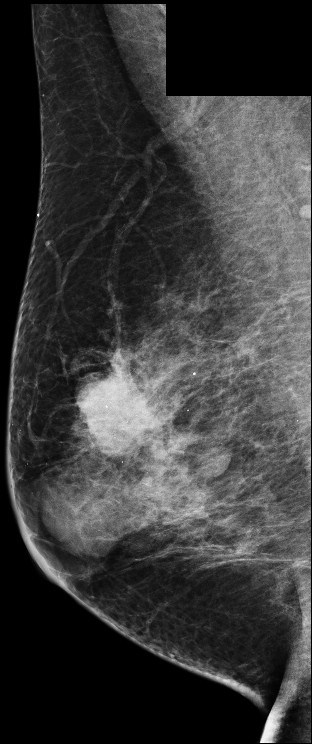

In [13]:
from PIL import Image, ImageFilter, ImageEnhance
i = Image.open('/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia7.png')
i

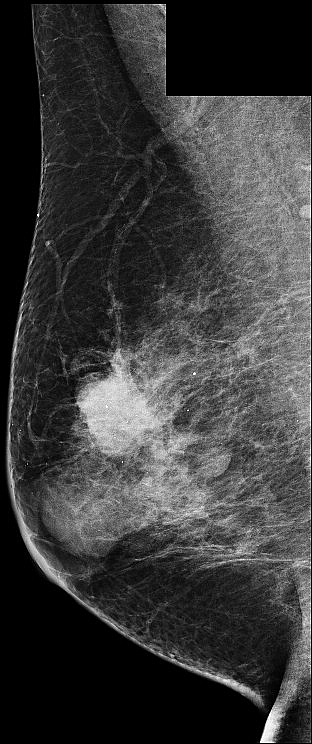

In [14]:
sharpener = ImageEnhance.Sharpness (i)
sharpened = sharpener.enhance(3.0)
sharpened.save('/Users/MayraBerrones/Documents/VisualCode/Prueba/Sharp-mal1.png')
ima2 = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/Sharp-mal1.png")
#im.save('normales/no-{}.png'.format(i))
ima2

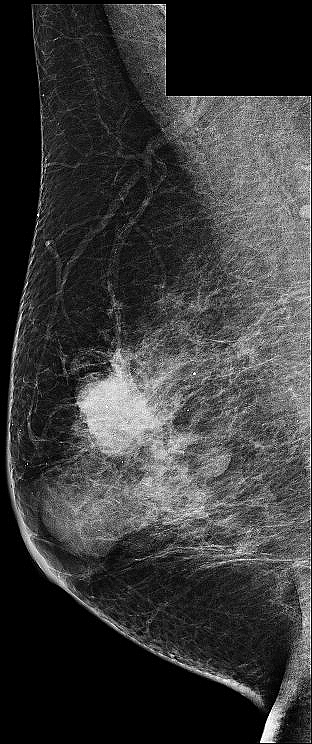

In [15]:
from PIL import Image, ImageFilter, ImageEnhance
i = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/Sharp-mal1.png")

i.filter(ImageFilter.DETAIL).save("/Users/MayraBerrones/Documents/VisualCode/Prueba/detail-m1.png")
detail = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/detail-m1.png")
#im.save('normales/no-{}.png'.format(i))
detail

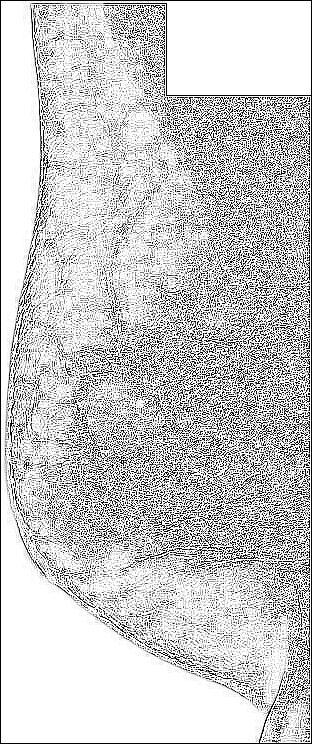

In [16]:
from PIL import Image, ImageFilter, ImageEnhance
i = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/detail-m1.png")

i.filter(ImageFilter.CONTOUR).save("/Users/MayraBerrones/Documents/VisualCode/Prueba/contour-m1.png")
contour = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/contour-m1.png")
contour

(312, 744)


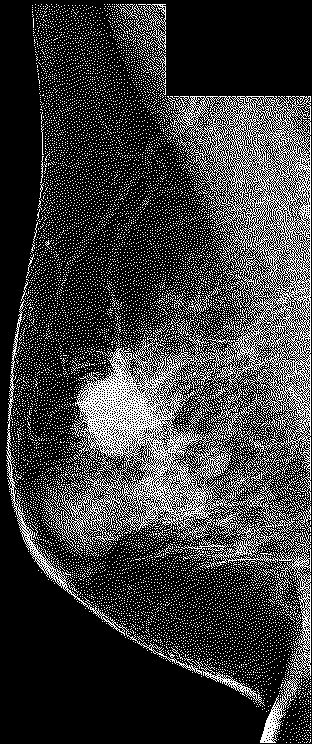

In [23]:
import ssl
import requests
imagen = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/detail-m1.png") 
nuevo = imagen.convert('1') 
print(nuevo.size)
nuevo.save('/Users/MayraBerrones/Documents/VisualCode/Prueba/detail_convert.png')
nuevo

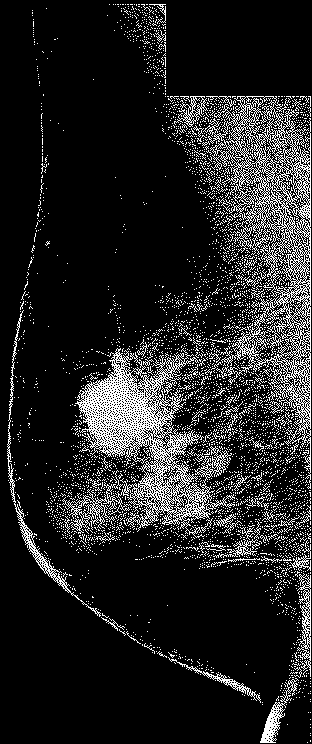

In [18]:
import ssl
import requests
from PIL import Image, ImageDraw
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

negro = (0, 0, 0)
blanco = (255, 255, 255)
umbral = 150 #90 era el primero
n = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/detail-m1.png") 
w, h = n.size
P = n.load()
for f in range(h): # bordes verticales
    if P[0, f] == blanco:
        ImageDraw.floodfill(n, (0, f), negro)
    if P[w - 1, f] == blanco:
        ImageDraw.floodfill(n, (w - 1, f), negro)
for c in range(w): # bordes horizontales
    if P[c, 0] == blanco:
        ImageDraw.floodfill(n, (c, 0), negro)
    if P[c, h - 1] == blanco:
        ImageDraw.floodfill(n, (c, h - 1), negro) 
for f in range(h): 
    for c in range(w):
        rgb = P[c, f]
        if max(rgb) - min(rgb) > umbral: # tiene un color que no es gris 
            P[c, f] = negro
b = n.convert('1') # binaricemos lo que queda
b.save('/Users/MayraBerrones/Documents/VisualCode/Prueba/rgb-m1.png')
b

8284 pixeles negros eliminados


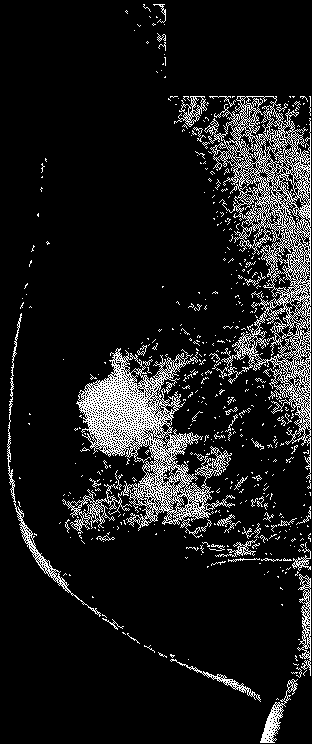

In [19]:
import ssl
import requests
from PIL import Image
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

nuevo = b 
P = nuevo.load()
ancho, altura = nuevo.size
borrados = 0
vecinos = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
for fila in range(altura):
    for columna in range(ancho):
        if P[columna, fila] == 255: # pixel es negro
            contador = 0
            for (df, dc) in vecinos:
                vf = fila + df
                vc = columna + dc
                if vf >= 0 and vc >= 0 and vf < altura and vc < ancho: # si existe el vecino
                    if P[vc, vf] == 255:
                        contador += 1
            if contador < 2: # uno o cero vecinos negros
                P[columna, fila] = 0 # será blanco
                borrados += 1
print(borrados, "pixeles negros eliminados")
nuevo.save('/Users/MayraBerrones/Documents/VisualCode/Prueba/pixeles-m1.png')
pixeles = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/pixeles-m1.png") 
pixeles

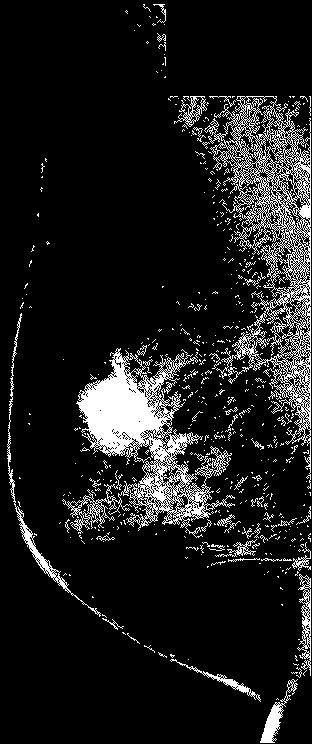

In [20]:
import ssl
import requests
from PIL import Image, ImageDraw
 
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

n = nuevo 
w, h = n.size
rgb = n.convert('RGB')
P = rgb.load()
negro = (0, 0, 0)
blanco = (255, 255, 255)
for f in range(h): # bordes verticales
    if P[0, f] == blanco:
        ImageDraw.floodfill(rgb, (0, f), negro)
    if P[w - 1, f] == blanco:
        ImageDraw.floodfill(rgb, (w - 1, f), negro)
for c in range(w): # bordes horizontales
    if P[c, 0] == blanco:
        ImageDraw.floodfill(rgb, (c, 0), negro)
    if P[c, h - 1] == blanco:
        ImageDraw.floodfill(rgb, (c, h - 1), negro) 
n = rgb.convert('1') 
P = n.load()
V = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
for f in range(1, h - 1): # sin bordes ahora
    for c in range(1, w - 1):
        if P[c, f] == 0: 
            cont = 0
            for (df, dc) in V:
                if P[c + dc, f + df] == 0: # siempre existen
                    cont += 1
            if cont < 2:
                P[c, f] = 255 #  blanco
n.save('/Users/MayraBerrones/Documents/VisualCode/Prueba/vecinos-m1.png')
vecinos = Image.open("/Users/MayraBerrones/Documents/VisualCode/Prueba/vecinos-m1.png")
vecinos

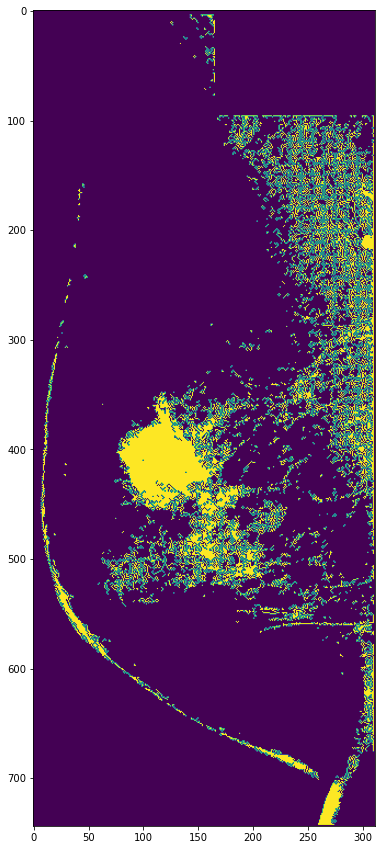

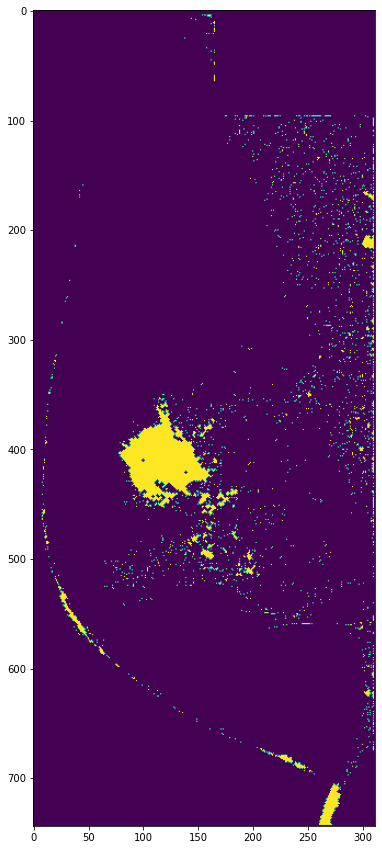

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline
im = io.imread('/Users/MayraBerrones/Documents/VisualCode/Prueba/vecinos-m1.png')
plt.figure(figsize=(15,15))
plt.imshow(im)
plt.savefig('/Users/MayraBerrones/Documents/VisualCode/Prueba/vecinossegmented-m1.png')

# Contoured image
ret,thresh = cv2.threshold(im, 120,255,cv2.THRESH_BINARY)
contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
for contour in contours:
   cv2.drawContours(im, contour, -1, (0, 255, 0), 1)
plt.figure(figsize=(15,15))

plt.imshow(im)